
Sales by Product Category:
                   Total_Revenue  Avg_Sales  Total_Quantity
Product Category                                          
Clothing                  420.0      420.0              14
Electronics              1760.0      880.0              21
Groceries                 300.0      300.0              30


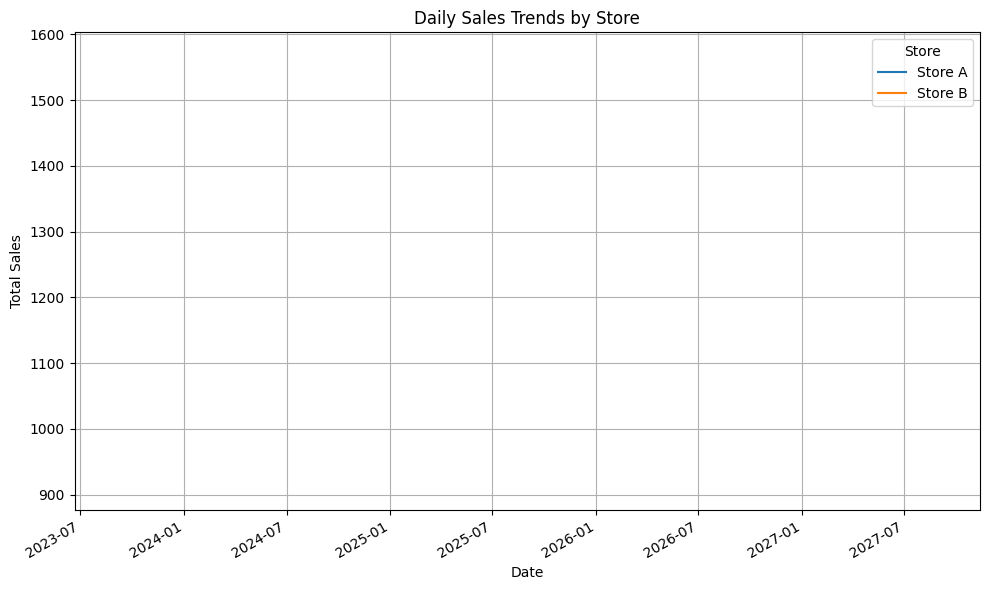

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('sales_data.csv', parse_dates=['Date'])

# 1. MultiIndexing by Store and Date
df.set_index(['Store', 'Date'], inplace=True)
df.sort_index(inplace=True)

# 2. Reshape data using melt(), stack(), unstack()

# Reset index for reshaping
df_reset = df.reset_index()  # In case it's still MultiIndexed

# Let's make a mini pivot to illustrate stack/unstack better
pivot_df = df_reset.pivot_table(index=['Store', 'Date'], 
                                 columns='Product Category', 
                                 values='Sales Amount')

# Now safely stack and unstack
stacked = pivot_df.stack()      # Turns Product Category into a row index
unstacked = stacked.unstack()
# 3. Rolling 7-day moving average of total sales per store
# First, group by Store and Date and sum Sales Amount
sales_daily = df_reset.groupby(['Store', 'Date'])['Sales Amount'].sum().sort_index()
# Apply rolling average
rolling_avg = sales_daily.groupby(level=0).rolling(window=7).mean().reset_index(level=0, drop=True)
df_rolling = sales_daily.to_frame(name='Total Sales')
df_rolling['7D_MA_Sales'] = rolling_avg

# 4. Replace loops with vectorized ops & .apply() instead of .iterrows()
# Vectorized calculation: Sales per unit
df['Sales per Unit'] = df['Sales Amount'] / df['Quantity Sold']

# Example .apply(): Classify performance level by sales amount
def classify_performance(row):
    if row['Sales Amount'] > 1000:
        return 'High'
    elif row['Sales Amount'] > 500:
        return 'Medium'
    else:
        return 'Low'

df['Performance'] = df.reset_index().apply(classify_performance, axis=1).values

# 5. Group by Product Category for revenue and avg sales
category_stats = df_reset.groupby('Product Category').agg(
    Total_Revenue=pd.NamedAgg(column='Sales Amount', aggfunc='sum'),
    Avg_Sales=pd.NamedAgg(column='Sales Amount', aggfunc='mean'),
    Total_Quantity=pd.NamedAgg(column='Quantity Sold', aggfunc='sum')
)

print("\nSales by Product Category:\n", category_stats)

# 6. Visualizations – Sales Trends
# Plot total sales per store over time
store_sales = df_reset.groupby(['Date', 'Store'])['Sales Amount'].sum().unstack()

store_sales.plot(figsize=(10,6), title='Daily Sales Trends by Store')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()
